In [1]:
import itertools
import math
import time

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython import display

In [2]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Load Dataset

In [3]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)) # changed
])

train_dataset = dsets.MNIST(root='./data/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

### Model

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.model(x.view(x.size(0), 784))
        out = out.view(out.size(0), -1)
        return out

In [5]:
random_input_size = 10

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(random_input_size, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), random_input_size)
        out = self.model(x)
        return out

In [7]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
generator.load_state_dict(torch.load("model_checkpoint/mnist_gan_generator.pth"))
discriminator.load_state_dict(torch.load("model_checkpoint/mnist_gan_discriminator.pth"))

RuntimeError: Error(s) in loading state_dict for Generator:
	Missing key(s) in state_dict: "model.0.bias", "model.2.weight", "model.2.bias", "model.6.bias". 
	Unexpected key(s) in state_dict: "model.9.weight", "model.10.weight", "model.10.bias", "model.10.running_mean", "model.10.running_var", "model.10.num_batches_tracked", "model.12.weight", "model.1.weight", "model.1.bias", "model.1.running_mean", "model.1.running_var", "model.1.num_batches_tracked", "model.3.weight", "model.4.running_mean", "model.4.running_var", "model.4.num_batches_tracked", "model.7.weight", "model.7.bias", "model.7.running_mean", "model.7.running_var", "model.7.num_batches_tracked". 
	size mismatch for model.0.weight: copying a param with shape torch.Size([25, 512, 4, 4]) from checkpoint, the shape in current model is torch.Size([256, 10]).
	size mismatch for model.4.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024, 512]).
	size mismatch for model.4.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for model.6.weight: copying a param with shape torch.Size([256, 128, 4, 4]) from checkpoint, the shape in current model is torch.Size([784, 1024]).

### Optimization

In [47]:
criterion = nn.BCELoss()
lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

### Training

In [48]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):
    discriminator.zero_grad()
    outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels.unsqueeze(1).to(device)) # changed
    real_score = outputs
    
    outputs = discriminator(fake_images) 
    fake_loss = criterion(outputs, fake_labels.unsqueeze(1).to(device)) # changed
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score

In [49]:
def train_generator(generator, discriminator_outputs, real_labels):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels.unsqueeze(1).to(device)) 
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [50]:
# draw samples from the input distribution to inspect the generation on training 
num_test_samples = 16
test_noise = torch.randn(num_test_samples, random_input_size).to(device)

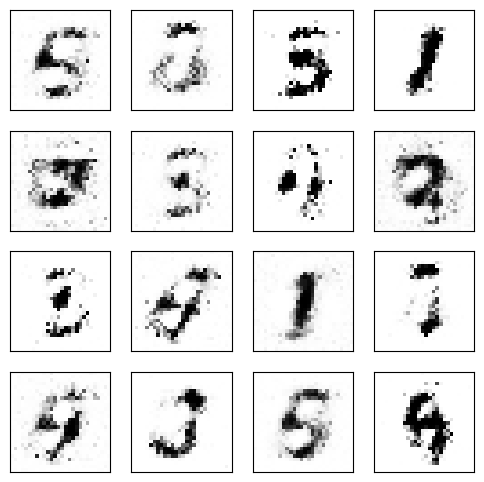

Epoch [3/200], Step[200/600],d_loss: 0.9280 g_loss: 1.8763843774795532,D(X): 0.79, D(G(z)): 0.30
Saved PyTorch Model State to /model/


KeyboardInterrupt: 

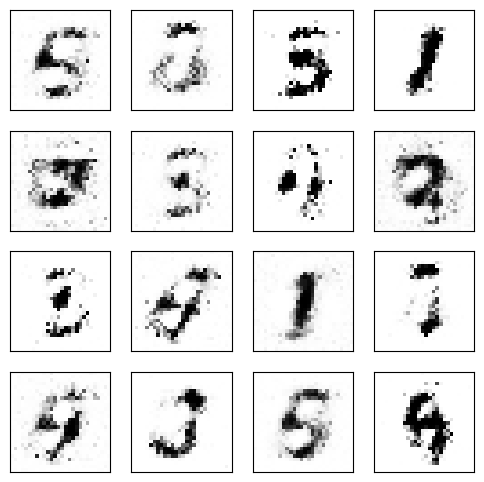

In [63]:
# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# set number of epochs and initialize figure counter
num_epochs = 200
num_batches = len(train_loader)
num_fig = 0


for epoch in range(num_epochs):
    for n, (images, _) in enumerate(train_loader):
        images = images.to(device)
        real_labels = torch.ones(images.size(0)).to(device)
        
        # Sample from generator
        noise = torch.randn(images.size(0), random_input_size).to(device)
        fake_images = generator(noise)
        fake_labels = torch.zeros(images.size(0)).to(device)
        
        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)
        
        # Sample again from the generator and get output from discriminator
        noise = torch.randn(images.size(0), random_input_size).to(device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images)

        # Train the generator
        g_loss = train_generator(generator, outputs, real_labels)
        
        if (n+1) % 100 == 0:
            test_images = generator(test_noise)
            
            for k in range(num_test_samples):
                i = k//4
                j = k%4
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            plt.savefig('results/mnist-gan-%03d.png'%num_fig)
            num_fig += 1
            print(f'Epoch [{epoch+1}/{num_epochs}], Step[{n+1}/{num_batches}],'
                  f'd_loss: {d_loss.data.item():.4f} g_loss: {g_loss.data.item()},'
                  f'D(X): {real_score.data.mean():.2f}, D(G(z)): {fake_score.data.mean():.2f}')

            # save param
            torch.save(generator.state_dict(), "model_checkpoint/mnist_gan_generator.pth")
            torch.save(discriminator.state_dict(), "model_checkpoint/mnist_gan_discriminator.pth")
            print("Saved PyTorch Model State to /model_checkpoint/")

fig.close()